<a href="https://colab.research.google.com/github/Ashik9576/Taxi-Time-Prediction/blob/main/Ashik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

# **Imporing the required Libraries**

In [54]:
# Importing the libraries
!pip install pycountry
!pip install haversine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pycountry as pc
import matplotlib.ticker as mtick
import plotly.express as px
from numpy import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [55]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Loading Data**

In [56]:
# creating directory path
nyc = pd.read_csv('/content/drive/MyDrive/NYC/NYC Taxi Data.csv')

**Creating Copy of Data**

In [57]:
# creating a copy
nycc=nyc.copy()

# **File Structure and content**

In [58]:
#no. of row and column
print("We have {} rows.".format(nycc.shape[0]))
print("We have {} columns.".format(nycc.shape[1]))
nycc.iloc[1,:]

We have 1458644 rows.
We have 11 columns.


id                              id2377394
vendor_id                               1
pickup_datetime       2016-06-12 00:43:35
dropoff_datetime      2016-06-12 00:54:38
passenger_count                         1
pickup_longitude                 -73.9804
pickup_latitude                   40.7386
dropoff_longitude                -73.9995
dropoff_latitude                  40.7312
store_and_fwd_flag                      N
trip_duration                         663
Name: 1, dtype: object

**At first galance, We have seen that the type of each variable and how they look like.**

# **MISSING VALUES**
Knowing about missing values is important because they indicate how much we dont's know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.


In [59]:
#check null values in Data frame
nyc.isnull().sum()


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

**Fortunately, in this dataset we do not have any missing values which is great**

In [7]:
#checking types of values in store_and_fwd_flag
nyc.store_and_fwd_flag.value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [61]:
# Visualizing the dataset
nycc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [62]:
# summery of dataframe
nyc.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [14]:
dmylp=[]                                               # storing date from pickup_datetime
hmslp=[]                                               # storing month from pickup_datetime
a=nycc['pickup_datetime']
for i in a:
  dmy=i.split()[0]
  hms=i.split()[1]
  dmylp.append(dmy)
  hmslp.append(hms)


dmyld=[]                                               # storing date from dropoff_datetime
hmsld=[]                                               # storing month from dropoff_datetime
b=nycc['dropoff_datetime']
for i in b:
  dmy=i.split()[0]
  hms=i.split()[1]
  dmyld.append(dmy)
  hmsld.append(hms)

In [15]:
yearp=[]                                  # pickup_datetime year
monthp=[]                                 #pickup_datetime month
dayp=[]                                   #pickup_datetime day
for i in dmylp:
  w=datetime.strptime(i,"%Y-%m-%d")
  yearp.append(w.year)
  monthp.append(w.month)
  dayp.append(w.day)


yeard=[]                                  # dropoff_datetime year
monthd=[]                                 #dropoff_datetime month
dayd=[]                                   #dropoff_datetime day
for i in dmyld:
  w=datetime.strptime(i,"%Y-%m-%d")
  yeard.append(w.year)
  monthd.append(w.month)
  dayd.append(w.day)



In [16]:
nycc['pickup_datetime_year']=yearp 
nycc['pickup_datetime_month']=monthp
nycc['pickup_datetime_day']=dayp
nycc['pickup_datetime_time']=hmslp
nycc['dropoff_datetime_year']=yeard
nycc['dripoff_datetime_month']=monthd
nycc['dropoff_datetime_day']=dayd
nycc['dropoff_datetime_time']=hmsld

In [17]:
nycc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_time,dropoff_datetime_year,dripoff_datetime_month,dropoff_datetime_day,dropoff_datetime_time
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,14,17:24:55,2016,3,14,17:32:30
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,12,00:43:35,2016,6,12,00:54:38
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,19,11:35:24,2016,1,19,12:10:48
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,6,19:32:31,2016,4,6,19:39:40
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,26,13:30:55,2016,3,26,13:38:10


In [18]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [19]:
#Calculate distance and assign new column to the dataframe.
nycc['distance_in_km'] = nycc.apply(lambda x: calc_distance(x), axis = 1)

In [20]:
nycc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_time,dropoff_datetime_year,dripoff_datetime_month,dropoff_datetime_day,dropoff_datetime_time,distance_in_km
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,14,17:24:55,2016,3,14,17:32:30,1.498523
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,12,00:43:35,2016,6,12,00:54:38,1.805510
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,19,11:35:24,2016,1,19,12:10:48,6.385107
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,6,19:32:31,2016,4,6,19:39:40,1.485500
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,26,13:30:55,2016,3,26,13:38:10,1.188590


In [21]:
nycc['trip_duration']=nycc['trip_duration']/3600
nycc['Speed_of_trip_in_km/h']= nycc['distance_in_km']/nycc['trip_duration']


In [22]:
nycc['store_and_fwd_flag'].replace({"N":1,'Y':0}, inplace=True)

In [23]:
nycc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_time,dropoff_datetime_year,dripoff_datetime_month,dropoff_datetime_day,dropoff_datetime_time,distance_in_km,Speed_of_trip_in_km/h
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,1,0.126389,2016,3,14,17:24:55,2016,3,14,17:32:30,1.498523,11.856445
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,1,0.184167,2016,6,12,00:43:35,2016,6,12,00:54:38,1.805510,9.803672
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,1,0.590000,2016,1,19,11:35:24,2016,1,19,12:10:48,6.385107,10.822216
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,1,0.119167,2016,4,6,19:32:31,2016,4,6,19:39:40,1.485500,12.465738
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,1,0.120833,2016,3,26,13:30:55,2016,3,26,13:38:10,1.188590,9.836608


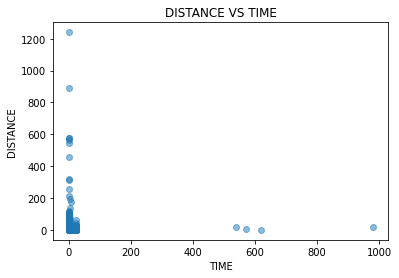

In [24]:
plt.scatter(nycc['trip_duration'], nycc['distance_in_km'], alpha=0.5)
plt.title('DISTANCE VS TIME')
plt.xlabel('TIME')
plt.ylabel('DISTANCE')
plt.show()

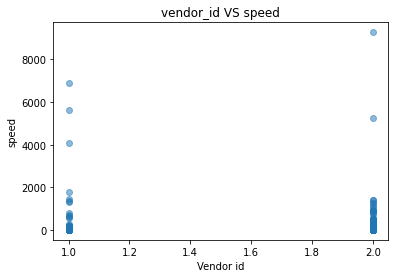

In [25]:
plt.scatter(nycc['vendor_id'], nycc['Speed_of_trip_in_km/h'], alpha=0.5)
plt.title('vendor_id VS speed')
plt.xlabel('Vendor id')
plt.ylabel('speed')
plt.show()

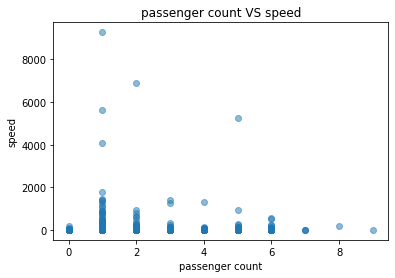

In [26]:
plt.scatter(nycc['passenger_count'], nycc['Speed_of_trip_in_km/h'], alpha=0.5)
plt.title('passenger count VS speed')
plt.xlabel('passenger count')
plt.ylabel('speed')
plt.show()

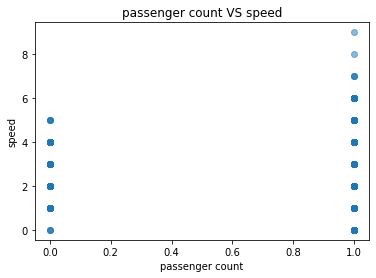

In [27]:
plt.scatter(nycc['store_and_fwd_flag'],nycc['passenger_count'], alpha=0.5)
plt.title('passenger count VS speed')
plt.xlabel('passenger count')
plt.ylabel('speed')
plt.show()

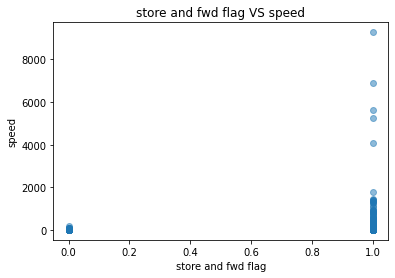

In [28]:
plt.scatter(nycc['store_and_fwd_flag'],nycc['Speed_of_trip_in_km/h'], alpha=0.5)
plt.title('store and fwd flag VS speed')
plt.xlabel('store and fwd flag')
plt.ylabel('speed')
plt.show()

Text(0, 0.5, 'speed in km/h')

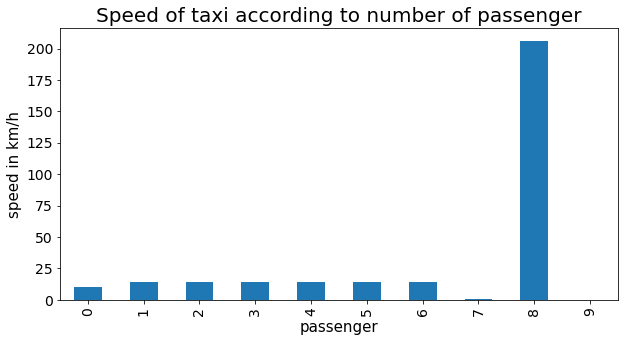

In [29]:
# Create the figure object 
ax = nycc.groupby(['passenger_count'])['Speed_of_trip_in_km/h'].mean().plot.bar(
    figsize = (10,5),
    fontsize = 14
)

# Set the title
ax.set_title("Speed of taxi according to number of passenger", fontsize = 20)

# Set x and y-labels
ax.set_xlabel("passenger", fontsize = 15)
ax.set_ylabel("speed in km/h", fontsize = 15)

In [30]:
dependent_variable= 'trip_duration'

In [31]:
# Create a list of independent variables
independent_variables = ['vendor_id','passenger_count','distance_in_km','store_and_fwd_flag']

In [32]:
independent_variables

['vendor_id', 'passenger_count', 'distance_in_km', 'store_and_fwd_flag']

In [33]:
# Create the data of independent variables
X = nycc[independent_variables].values

# Create the dependent variable data
y = nycc[dependent_variable].values

In [34]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [35]:
# Transforming data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
regressor.intercept_

0.13174322474522063

In [38]:
regressor.coef_

array([ 5.64357023e-02,  2.15714221e-02,  2.97195051e+01, -1.44128226e-02])

In [39]:
y_pred_train = regressor.predict(X_train)

In [40]:
y_train

array([0.02138889, 0.08777778, 0.35444444, ..., 0.27638889, 0.22805556,
       0.1075    ])

In [41]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)

In [42]:
#Predicted time on the test data
y_pred

array([0.19100028, 0.7117258 , 0.41128558, ..., 0.27183368, 0.27070338,
       0.17074732])

In [43]:
# Actual time on test data
y_test

array([0.03138889, 0.56583333, 0.50305556, ..., 0.15055556, 0.26861111,
       0.16888889])

In [44]:
mean_squared_error(y_test, y_pred)

4.030760416281005

In [45]:
# Train performance
math.sqrt(mean_squared_error(y_train, y_pred_train))

1.270145060939808

In [46]:
# Test performance
math.sqrt(mean_squared_error(y_test, y_pred))

2.0076753762202206

In [47]:
r2_score(y_train, y_pred_train)

0.012453349954775872

In [48]:
r2_score(y_test, y_pred)

0.004349486227467447